In [ ]:
pip install Pillow

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
import glob
import copy
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
from skimage import io, transform
from torchvision import transforms, utils

In [ ]:
# mounting drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/COS429_Final_Project/

/content/drive/MyDrive/COS429_Final_Project


In [ ]:
#classes = {'BREAK': 0, 'BUY': 1, 'CLEAN': 2, 'NO': 3, 'NOT': 4, 'WHY': 5, 'BREAKDOWN': 6, 'CANCEL': 7, 'FRIEND': 8, 'NONE': 9, 'PARTY': 10}
class_name = {'BREAK': 0, 'BUY': 1, 'CLEAN': 2, 'NO': 3, 'NOT': 4, 'WHY': 5}

In [ ]:
'''for class_name in classes.keys():
  os.system('mkdir ' +class_name)
  for folder in os.listdir('/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATASET/'+ class_name):
    if '.' not in folder:
      os.system('mkdir ' + class_name + '/'+folder+'/')
      os.system('cp /content/drive/MyDrive/COS429_Final_Project/BOSTON_DATASET/'+ class_name + '/'+folder+'/* ' +class_name+ '/'+folder+'/')'''

"for class_name in classes.keys():\n  os.system('mkdir ' +class_name)\n  for folder in os.listdir('/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATASET/'+ class_name):\n    if '.' not in folder:\n      os.system('mkdir ' + class_name + '/'+folder+'/')\n      os.system('cp /content/drive/MyDrive/COS429_Final_Project/BOSTON_DATASET/'+ class_name + '/'+folder+'/* ' +class_name+ '/'+folder+'/')"

In [ ]:
'''for class_name in classes.keys():
  files = os.listdir(path+class_name)
  for file in files:
    if '.' in file:
      # print('rm -rf '+path+class_name+'/'+file)
      os.system('rm -rf '+path+class_name+'/'+file)'''

"for class_name in classes.keys():\n  files = os.listdir(path+class_name)\n  for file in files:\n    if '.' in file:\n      # print('rm -rf '+path+class_name+'/'+file)\n      os.system('rm -rf '+path+class_name+'/'+file)"

In [ ]:
# following this tutorial: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# old image
# path = '/content/drive/MyDrive/COS429_Final_Project/signs_images/train'

# new path to get static images for CNN
path = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA5_COLOR/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 6 # change when done finetuning

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params

feature_extract = False

In [ ]:
from google.colab.patches import cv2_imshow
from imgaug import augmenters as iaa
# sampler is used to get valid indices for batches of sequences of imgs
class ImageSampler(torch.utils.data.Sampler):
    def __init__(self, end_idx, seq_length):        
        indices = []
        #print(end_idx)
        for i in range(len(end_idx)-1):
            start = end_idx[i]
            end = end_idx[i+1] - seq_length
            if (start > end): 
              break
            indices.append(torch.arange(start, end))
        indices = torch.cat(indices)
        self.indices = indices
        
    def __iter__(self):
        indices = self.indices[torch.randperm(len(self.indices))]
        return iter(indices.tolist())
    
    def __len__(self):
        return len(self.indices)

# homemade dataset to get sequences of images for LSTM 
class ImageSequenceDataset(Dataset):
                                                                    #AUG
    def __init__(self, image_paths, seq_length, transform, length, train):
        self.image_paths = image_paths
        self.seq_length = seq_length
        self.transform = transform
        self.length = length
        #AUG
        self.train = train 
        
    def __getitem__(self, index):
        start = index
        end = index + self.seq_length
        #print('Getting images from {} to {}'.format(start, end))
        indices = list(range(start, end))
        images = []
        #AUG
        coarsedrop = np.random.uniform()
        sp = np.random.uniform()
        gc = np.random.uniform(0, 5)
        aug = iaa.Sequential([
                         iaa.CoarseDropout(coarsedrop, size_percent=sp), 
                         iaa.GammaContrast(gc), 
                         iaa.Fliplr(p=1.0)])
        #AUG
        p = np.random.uniform()
        for i in indices:
            image_path = self.image_paths[i][0]
            image = cv2.imread(image_path)
            #AUG
            if p > 0.5 and self.train:
              image = aug(image=image)
            image = Image.fromarray(image)
            if self.transform:
              image = self.transform(image)
            #show(image)
            images.append(image)
        image_stack = torch.stack(images)
        #print(self.image_paths[i][0].split('/')[7])
        label = class_name[self.image_paths[i][0].split('/')[7]]
        #print(label)
        return image_stack, label
        # return images, label
    
    def __len__(self):
        return self.length

In [ ]:
root_dir = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/train'
class_paths = [d.path for d in os.scandir(root_dir) if d.is_dir]

class_image_paths = []
end_idx = []
for c, class_path in enumerate(class_paths):
    for d in os.scandir(class_path):
        if d.is_dir:
            paths = sorted(glob.glob(os.path.join(d.path, '*.jpg')))
            #print(d.path)
            # Add class idx to paths
            paths = [(p, c) for p in paths]
            class_image_paths.extend(paths)
            end_idx.extend([len(paths)])

end_idx = [0, *end_idx]
end_idx = torch.cumsum(torch.tensor(end_idx), 0)
seq_length = 3

sampler = ImageSampler(end_idx, seq_length)
input_size = 224

# TODO: Fix transformer dimensions
transform = transforms.Compose([
        transforms.Resize((input_size)),  
        transforms.CenterCrop(input_size),                     
        # transforms.RandomResizedCrop(input_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageSequenceDataset(
    image_paths=class_image_paths,
    seq_length=seq_length,
    transform=transform,
    length=len(sampler), 
    #AUG
    train=True)


loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=sampler
)


dataloaders_dict_train = {x: loader for x in ['train']}

In [ ]:
# Display resulting image
inputs, classes = next(iter(dataloaders_dict_train['train']))  

clip = inputs[0]
fig, axes = plt.subplots(2, seq_length)
for img_idx in range(seq_length):
    img = clip[img_idx]
    img_display = torch.transpose(img.data, 0, 2)
    img_display = torch.transpose(img_display, 0, 1)
    axes[0, img_idx].imshow(img_display)
    axes[0, img_idx].axis('off')
    axes[0, 0].set_title('original clip')
plt.show()

In [ ]:
root_dir = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/val'
class_paths = [d.path for d in os.scandir(root_dir) if d.is_dir]

class_image_paths = []
end_idx = []
for c, class_path in enumerate(class_paths):
    for d in os.scandir(class_path):
        if d.is_dir:
            paths = sorted(glob.glob(os.path.join(d.path, '*.jpg')))
            #print(d.path)
            # Add class idx to paths
            paths = [(p, c) for p in paths]
            class_image_paths.extend(paths)
            end_idx.extend([len(paths)])

end_idx = [0, *end_idx]
end_idx = torch.cumsum(torch.tensor(end_idx), 0)
seq_length = 3

sampler = ImageSampler(end_idx, seq_length)
input_size = 224

# TODO: Fix transformer dimensions
transform = transforms.Compose([
        transforms.Resize((input_size)),  
        transforms.CenterCrop(input_size),                     
        # transforms.RandomResizedCrop(input_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageSequenceDataset(
    image_paths=class_image_paths,
    seq_length=seq_length,
    transform=transform,
    length=len(sampler), 
    #AUG
    train=False)


loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=sampler
)


dataloaders_dict_val = {x: loader for x in ['val']}

In [ ]:
# Display resulting image
inputs, classes = next(iter(dataloaders_dict_train['train']))  

clip = inputs[0]
fig, axes = plt.subplots(2, seq_length)
for img_idx in range(seq_length):
    img = clip[img_idx]
    img_display = torch.transpose(img.data, 0, 2)
    img_display = torch.transpose(img_display, 0, 1)
    axes[0, img_idx].imshow(img_display)
    axes[0, img_idx].axis('off')
    axes[0, 0].set_title('original clip')
plt.show()

In [ ]:
import torch.nn.functional as F
class ResCRNN(nn.Module):
    def __init__(self, sample_size=256, sample_duration=seq_length, num_classes=num_classes,
                lstm_hidden_size=512, lstm_num_layers=1, arch="resnet18",
                attention=False):
        super(ResCRNN, self).__init__()
        self.sample_size = sample_size
        self.sample_duration = sample_duration
        self.num_classes = num_classes

        # network params
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.attention = attention

        # network architecture
        if arch == "resnet18":
            resnet = models.resnet18(pretrained=True)
        elif arch == "resnet34":
            resnet = models.resnet34(pretrained=True)
        elif arch == "resnet50":
            resnet = models.resnet50(pretrained=True)
        elif arch == "resnet101":
            resnet = models.resnet101(pretrained=True)
        elif arch == "resnet152":
            resnet = models.resnet152(pretrained=True)
        elif arch == 'alexnet':
            resnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
        elif arch =='vgg':
            resnet = models.vgg16(pretrained=True)
        elif arch =='inception':
            resnet = models.inception_v3(pretrained=True)
        # delete the last fc layer
        modules = list(resnet.children())[:-1]
        self.conv = nn.Sequential(*modules)
        #print(self.conv)
        #print('inception in features', resnet.fc.in_features)
        self.lstm = nn.LSTM(
            input_size=resnet.fc.in_features,
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_num_layers,
            batch_first=True,
        )
        if self.attention:
            self.attn_block = LSTMAttentionBlock(hidden_size=self.lstm_hidden_size)
        #self.fc1 = nn.Linear(self.lstm_hidden_size, num_classes)
        self.fc1 = nn.Linear(self.lstm_hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # CNN
        cnn_embed_seq = []
        # x: (batch_size, t, channel, h, w)
        for t in range(x.size(1)):
            # with torch.no_grad():
            #print('pre conv')
            #print(x[:, t, :, :, :].shape)
            out = self.conv(x[:, t, :, :, :])
            #print('post conv shape', out.shape)
            # print(out.shape)
            out = out.view(out.size(0), -1)
            cnn_embed_seq.append(out)

        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0)
        # print(cnn_embed_seq.shape)
        # batch first
        cnn_embed_seq = cnn_embed_seq.transpose_(0, 1)

        # LSTM
        # use faster code paths
        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(cnn_embed_seq, None)
        # MLP
        if self.attention:
            out = self.fc1(self.attn_block(out))
        else:
            # out: (batch, seq, feature), choose the last time step
            out = self.fc1(out)
            out = F.relu(out)
            out = self.fc2(out[:, -1, :])


        return out

In [ ]:
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_epoch(model, criterion, optimizer, dataloader, device, epoch, logger, log_interval, writer):
    model.train()
    losses = []
    all_label = []
    all_pred = []

    for batch_idx, data in enumerate(dataloader):
        # get the inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        if isinstance(outputs, list):
            outputs = outputs[0]

        # compute the loss
        #print('labels into loss function: ', labels)
        loss = criterion(outputs, labels.squeeze())
        losses.append(loss.item())

        # compute the accuracy
        prediction = torch.max(outputs, 1)[1]
        all_label.extend(labels.squeeze())
        all_pred.extend(prediction)
        score = accuracy_score(labels.squeeze().cpu().data.squeeze().numpy(), prediction.cpu().data.squeeze().numpy())

        # backward & optimize
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % log_interval == 0:
            print("epoch {:3d} | iteration {:5d} | Loss {:.6f} | Acc {:.2f}%".format(epoch+1, batch_idx+1, loss.item(), score*100))
            logger.info("epoch {:3d} | iteration {:5d} | Loss {:.6f} | Acc {:.2f}%".format(epoch+1, batch_idx+1, loss.item(), score*100))

    # Compute the average loss & accuracy
    training_loss = sum(losses)/len(losses)
    all_label = torch.stack(all_label, dim=0)
    all_pred = torch.stack(all_pred, dim=0)
    training_acc = accuracy_score(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy())
    # Log
    writer.add_scalars('Loss', {'train': training_loss}, epoch+1)
    writer.add_scalars('Accuracy', {'train': training_acc}, epoch+1)
    logger.info("Average Training Loss of Epoch {}: {:.6f} | Acc: {:.2f}%".format(epoch+1, training_loss, training_acc*100))
    print("Average Training Loss of Epoch {}: {:.6f} | Acc: {:.2f}%".format(epoch+1, training_loss, training_acc*100))
    return training_loss, training_acc

In [ ]:
def val_epoch(model, criterion, dataloader, device, epoch, logger, writer):
    model.eval()
    losses = []
    all_label = []
    all_pred = []

    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            # get the inputs and labels
            inputs, labels = data[0].to(device), data[1].to(device)
            # forward
            outputs = model(inputs)
            if isinstance(outputs, list):
                outputs = outputs[0]
            # compute the loss
            #print('labels into loss function: ', labels)
            if outputs.size(0) < 3: 
              break
            #print(labels.squeeze().size(0))
            loss = criterion(outputs, labels.squeeze())
            losses.append(loss.item())
            # collect labels & prediction
            prediction = torch.max(outputs, 1)[1]
            all_label.extend(labels.squeeze())
            all_pred.extend(prediction)
    # Compute the average loss & accuracy
    validation_loss = sum(losses)/len(losses)
    all_label = torch.stack(all_label, dim=0)
    all_pred = torch.stack(all_pred, dim=0)
    validation_acc = accuracy_score(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy())
    # Log
    writer.add_scalars('Loss', {'validation': validation_loss}, epoch+1)
    writer.add_scalars('Accuracy', {'validation': validation_acc}, epoch+1)
    print("Average Validation Loss of Epoch {}: {:.6f} | Acc: {:.2f}%".format(epoch+1, validation_loss, validation_acc*100))
    logger.info("Average Validation Loss of Epoch {}: {:.6f} | Acc: {:.2f}%".format(epoch+1, validation_loss, validation_acc*100))
    return validation_loss, validation_acc

In [ ]:
import os
import sys
from datetime import datetime
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
'''
from models.ConvLSTM import CRNN, ResCRNN
from dataset import CSL_Isolated
from train import train_epoch
from validation import val_epoch
'''

# Path setting
#model_path = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA5_COLOR/cnnlstm_models'
#log_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA5_COLOR/logs/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
#sum_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA5_COLOR/runs/slr_cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())
model_path = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/cnnlstm_models'
log_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/logh/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
sum_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/runs/slr_cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())
#model_path = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL/cnnlstm_models'
#log_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL/log/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
#sum_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL/runs/slr_cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())

# Log to file & tensorboard writer
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_path), logging.StreamHandler()])
logger = logging.getLogger('SLR')
logger.info('Logging to file...')
writer = SummaryWriter(sum_path)

# Device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparams
epochs = 15
batch_size = batch_size #3
learning_rate = 0.0005013740714335444
weight_decay = 2.7280602855311857e-05
log_interval = 20
sample_size = 299 #224
sample_duration = seq_length # 5
num_classes = num_classes # 64
lstm_hidden_size = 512
lstm_num_layers = 1
attention = False
model_count = 1
# Train with Conv+LSTM
if __name__ == '__main__':
    # Load data
    train_loader = dataloaders_dict_train['train']
    val_loader = dataloaders_dict_val['val']
    # Create model
    # model = CRNN(sample_size=sample_size, sample_duration=sample_duration, num_classes=num_classes,
    #             lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers).to(device)
    model = ResCRNN(sample_size=sample_size, sample_duration=sample_duration, num_classes=num_classes,
                lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers, attention=attention).to(device)
    # Run the model parallelly
    if torch.cuda.device_count() > 1:
        logger.info("Using {} GPUs".format(torch.cuda.device_count()))
        model = nn.DataParallel(model)
    # Create loss criterion & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Start training
    logger.info("Training Started".center(60, '#'))
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        # Train the model
        print('training model')
        training_loss, training_acc = train_epoch(model, criterion, optimizer, train_loader, device, epoch, logger, log_interval, writer)
        train_loss.append(training_loss)
        train_acc.append(training_acc)

        # Validate the model
        print('validating model')
        valid_loss, valid_acc =val_epoch(model, criterion, val_loader, device, epoch, logger, writer)
        val_loss.append(valid_loss)
        val_acc.append(valid_acc)

        # Save model
        torch.save(model.state_dict(), os.path.join(model_path, "slr_convlstm_epoch{:03d}.pth".format(epoch+1)))
        logger.info("Epoch {} Model Saved".format(epoch+1).center(60, '#'))

    logger.info("Training Finished".center(60, '#'))

    plt.plot(train_loss, '-o', color='red', label='train-loss')
    plt.plot(train_acc, '-o', color='green', label='train-acc')
    plt.plot(val_loss, '-o', color='blue', label='val-loss')
    plt.plot(val_acc, '-o', color='orange', label='val-acc')

    plt.savefig('/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/plots/' + 'model' + str(model_count) + '.png')

Logging to file...
######################Training Started######################


Epoch:  0
training model


epoch   1 | iteration    20 | Loss 1.028459 | Acc 56.25%


epoch   1 | iteration    20 | Loss 1.028459 | Acc 56.25%


epoch   1 | iteration    40 | Loss 0.523805 | Acc 87.50%


epoch   1 | iteration    40 | Loss 0.523805 | Acc 87.50%


Average Training Loss of Epoch 1: 0.879985 | Acc: 66.91%


Average Training Loss of Epoch 1: 0.879985 | Acc: 66.91%
validating model


Average Validation Loss of Epoch 1: 1.369630 | Acc: 61.51%


Average Validation Loss of Epoch 1: 1.369630 | Acc: 61.51%


####################Epoch 1 Model Saved#####################


Epoch:  1
training model


epoch   2 | iteration    20 | Loss 0.854063 | Acc 75.00%


epoch   2 | iteration    20 | Loss 0.854063 | Acc 75.00%


epoch   2 | iteration    40 | Loss 0.238350 | Acc 93.75%


epoch   2 | iteration    40 | Loss 0.238350 | Acc 93.75%


Average Training Loss of Epoch 2: 0.346104 | Acc: 89.90%


Average Training Loss of Epoch 2: 0.346104 | Acc: 89.90%
validating model


Average Validation Loss of Epoch 2: 0.829428 | Acc: 69.07%


Average Validation Loss of Epoch 2: 0.829428 | Acc: 69.07%


####################Epoch 2 Model Saved#####################


Epoch:  2
training model


epoch   3 | iteration    20 | Loss 0.665380 | Acc 75.00%


epoch   3 | iteration    20 | Loss 0.665380 | Acc 75.00%


epoch   3 | iteration    40 | Loss 0.062443 | Acc 100.00%


epoch   3 | iteration    40 | Loss 0.062443 | Acc 100.00%


Average Training Loss of Epoch 3: 0.295860 | Acc: 90.63%


Average Training Loss of Epoch 3: 0.295860 | Acc: 90.63%
validating model


Average Validation Loss of Epoch 3: 1.405895 | Acc: 60.48%


Average Validation Loss of Epoch 3: 1.405895 | Acc: 60.48%


####################Epoch 3 Model Saved#####################


Epoch:  3
training model


epoch   4 | iteration    20 | Loss 0.668180 | Acc 68.75%


epoch   4 | iteration    20 | Loss 0.668180 | Acc 68.75%


epoch   4 | iteration    40 | Loss 0.135890 | Acc 93.75%


epoch   4 | iteration    40 | Loss 0.135890 | Acc 93.75%


Average Training Loss of Epoch 4: 0.191661 | Acc: 93.85%


Average Training Loss of Epoch 4: 0.191661 | Acc: 93.85%
validating model


Average Validation Loss of Epoch 4: 1.172649 | Acc: 65.29%


Average Validation Loss of Epoch 4: 1.172649 | Acc: 65.29%


####################Epoch 4 Model Saved#####################


Epoch:  4
training model


epoch   5 | iteration    20 | Loss 0.211839 | Acc 93.75%


epoch   5 | iteration    20 | Loss 0.211839 | Acc 93.75%


epoch   5 | iteration    40 | Loss 0.038049 | Acc 100.00%


epoch   5 | iteration    40 | Loss 0.038049 | Acc 100.00%


Average Training Loss of Epoch 5: 0.174724 | Acc: 95.17%


Average Training Loss of Epoch 5: 0.174724 | Acc: 95.17%
validating model


Average Validation Loss of Epoch 5: 0.866126 | Acc: 74.57%


Average Validation Loss of Epoch 5: 0.866126 | Acc: 74.57%


####################Epoch 5 Model Saved#####################


Epoch:  5
training model


epoch   6 | iteration    20 | Loss 0.026805 | Acc 100.00%


epoch   6 | iteration    20 | Loss 0.026805 | Acc 100.00%


epoch   6 | iteration    40 | Loss 0.074684 | Acc 100.00%


epoch   6 | iteration    40 | Loss 0.074684 | Acc 100.00%


Average Training Loss of Epoch 6: 0.183761 | Acc: 94.44%


Average Training Loss of Epoch 6: 0.183761 | Acc: 94.44%
validating model


Average Validation Loss of Epoch 6: 1.288256 | Acc: 65.98%


Average Validation Loss of Epoch 6: 1.288256 | Acc: 65.98%


####################Epoch 6 Model Saved#####################


Epoch:  6
training model


epoch   7 | iteration    20 | Loss 0.081181 | Acc 100.00%


epoch   7 | iteration    20 | Loss 0.081181 | Acc 100.00%


epoch   7 | iteration    40 | Loss 0.153836 | Acc 93.75%


epoch   7 | iteration    40 | Loss 0.153836 | Acc 93.75%


Average Training Loss of Epoch 7: 0.152594 | Acc: 95.46%


Average Training Loss of Epoch 7: 0.152594 | Acc: 95.46%
validating model


Average Validation Loss of Epoch 7: 1.425477 | Acc: 64.26%


Average Validation Loss of Epoch 7: 1.425477 | Acc: 64.26%


####################Epoch 7 Model Saved#####################


Epoch:  7
training model


epoch   8 | iteration    20 | Loss 0.020524 | Acc 100.00%


epoch   8 | iteration    20 | Loss 0.020524 | Acc 100.00%


epoch   8 | iteration    40 | Loss 0.029867 | Acc 100.00%


epoch   8 | iteration    40 | Loss 0.029867 | Acc 100.00%


Average Training Loss of Epoch 8: 0.135583 | Acc: 95.90%


Average Training Loss of Epoch 8: 0.135583 | Acc: 95.90%
validating model


Average Validation Loss of Epoch 8: 1.086358 | Acc: 74.23%


Average Validation Loss of Epoch 8: 1.086358 | Acc: 74.23%


####################Epoch 8 Model Saved#####################


Epoch:  8
training model


epoch   9 | iteration    20 | Loss 0.271598 | Acc 87.50%


epoch   9 | iteration    20 | Loss 0.271598 | Acc 87.50%


epoch   9 | iteration    40 | Loss 0.108220 | Acc 93.75%


epoch   9 | iteration    40 | Loss 0.108220 | Acc 93.75%


Average Training Loss of Epoch 9: 0.108754 | Acc: 96.78%


Average Training Loss of Epoch 9: 0.108754 | Acc: 96.78%
validating model


Average Validation Loss of Epoch 9: 1.257669 | Acc: 67.70%


Average Validation Loss of Epoch 9: 1.257669 | Acc: 67.70%


####################Epoch 9 Model Saved#####################


Epoch:  9
training model


epoch  10 | iteration    20 | Loss 0.208071 | Acc 93.75%


epoch  10 | iteration    20 | Loss 0.208071 | Acc 93.75%


epoch  10 | iteration    40 | Loss 0.007939 | Acc 100.00%


epoch  10 | iteration    40 | Loss 0.007939 | Acc 100.00%


Average Training Loss of Epoch 10: 0.085637 | Acc: 97.51%


Average Training Loss of Epoch 10: 0.085637 | Acc: 97.51%
validating model


Average Validation Loss of Epoch 10: 1.174886 | Acc: 70.45%


Average Validation Loss of Epoch 10: 1.174886 | Acc: 70.45%


####################Epoch 10 Model Saved####################
#####################Training Finished######################


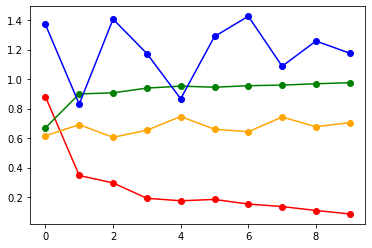

In [ ]:
import os
import sys
from datetime import datetime
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
'''
from models.ConvLSTM import CRNN, ResCRNN
from dataset import CSL_Isolated
from train import train_epoch
from validation import val_epoch
'''

# Path setting
#model_path = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA5_COLOR/cnnlstm_models'
#log_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA5_COLOR/logs/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
#sum_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA5_COLOR/runs/slr_cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())
model_path = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/cnnlstm_models'
log_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/logh/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
sum_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/runs/slr_cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())
#model_path = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL/cnnlstm_models'
#log_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL/log/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
#sum_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA_28_TRAINVAL/runs/slr_cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())

# Log to file & tensorboard writer
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_path), logging.StreamHandler()])
logger = logging.getLogger('SLR')
logger.info('Logging to file...')
writer = SummaryWriter(sum_path)

# Device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparams
epochs = 15
batch_size = batch_size #3
#learning_rate = 0.0005013740714335444
#weight_decay = 2.7280602855311857e-05

learning_rate = 7.618935788137979e-05
weight_decay = 0.02587591092706272
log_interval = 20
sample_size = 299 #224
sample_duration = seq_length # 5
num_classes = num_classes # 64
lstm_hidden_size = 512
lstm_num_layers = 1
attention = False
model_count = 1
# Train with Conv+LSTM
if __name__ == '__main__':
    # Load data
    train_loader = dataloaders_dict_train['train']
    val_loader = dataloaders_dict_val['val']
    # Create model
    # model = CRNN(sample_size=sample_size, sample_duration=sample_duration, num_classes=num_classes,
    #             lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers).to(device)
    model = ResCRNN(sample_size=sample_size, sample_duration=sample_duration, num_classes=num_classes,
                lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers, attention=attention).to(device)
    # Run the model parallelly
    if torch.cuda.device_count() > 1:
        logger.info("Using {} GPUs".format(torch.cuda.device_count()))
        model = nn.DataParallel(model)
    # Create loss criterion & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Start training
    logger.info("Training Started".center(60, '#'))
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        # Train the model
        print('training model')
        training_loss, training_acc = train_epoch(model, criterion, optimizer, train_loader, device, epoch, logger, log_interval, writer)
        train_loss.append(training_loss)
        train_acc.append(training_acc)

        # Validate the model
        print('validating model')
        valid_loss, valid_acc =val_epoch(model, criterion, val_loader, device, epoch, logger, writer)
        val_loss.append(valid_loss)
        val_acc.append(valid_acc)

        # Save model
        torch.save(model.state_dict(), os.path.join(model_path, "slr_convlstm_epoch{:03d}.pth".format(epoch+1)))
        logger.info("Epoch {} Model Saved".format(epoch+1).center(60, '#'))

    logger.info("Training Finished".center(60, '#'))

    plt.plot(train_loss, '-o', color='red', label='train-loss')
    plt.plot(train_acc, '-o', color='green', label='train-acc')
    plt.plot(val_loss, '-o', color='blue', label='val-loss')
    plt.plot(val_acc, '-o', color='orange', label='val-acc')

    plt.savefig('/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/plots/' + 'model' + str(model_count) + '.png')

In [ ]:
import numpy as np
import os
import sys
from datetime import datetime
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

# Device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
train_loader = dataloaders_dict_train['train']
val_loader = dataloaders_dict_val['val']
max_count = 20

# Hyperparams

batch_size = 16 #3
log_interval = 20
sample_size = input_size #224
sample_duration = seq_length # 5
num_classes = num_classes # 64
lstm_hidden_size = 512
lstm_num_layers = 1
attention = False

def hyperparamsearch():
  logh_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/logh/params_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
  sumh_path = "/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/runs/slr_cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())
  # Log to file & tensorboard writer
  logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(logh_path), logging.StreamHandler()])
  logger = logging.getLogger('SLR')
  logger.info('Logging to file...')
  writer = SummaryWriter(sumh_path)
  epochs = 5
  logger.info("Hyper Params Started".center(60, '#'))
  for count in range(max_count):
    wd = 10**np.random.uniform(-3, 1)
    lr = 10**np.random.uniform(-3, -5)
    logger.info("lr {} wd {}".format(lr, wd))
    # init model 
    model = ResCRNN(sample_size=sample_size, sample_duration=sample_duration, num_classes=num_classes,
              lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers, attention=attention).to(device)
    # Run the model parallelly
    if torch.cuda.device_count() > 1:
        logger.info("Using {} GPUs".format(torch.cuda.device_count()))
        model = nn.DataParallel(model)
    # Create loss criterion & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Start training
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        # Train the model
        print('training model')
        training_loss, training_acc = train_epoch(model, criterion, optimizer, train_loader, device, epoch, logger, log_interval, writer)
        train_loss.append(training_loss)
        train_acc.append(training_acc)
        
        # Validate the model
        print('validating model')
        valid_loss, valid_acc =val_epoch(model, criterion, val_loader, device, epoch, logger, writer)
        val_loss.append(valid_loss)
        val_acc.append(valid_acc)

        # Save model
        #torch.save(model.state_dict(), os.path.join(model_path, "slr_hyperparam_epoch{:03d}.pth".format(epoch+1)))
        logger.info("Epoch {} Model Saved".format(epoch+1).center(60, '#'))
    plt.clf()
    plt.title('Train-Val Accuracy and Loss')
    plt.plot(train_loss, '-o', color='red')
    plt.plot(train_acc, '-o', color='green')
    plt.plot(val_loss, '-o', color='blue')
    plt.plot(val_acc, '-o', color='orange')
    plt.savefig('/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/plots/' + 'hyperparam-lr' + str(lr) + 'wd' + str(wd) + '.png')

  logger.info("HyperParams Finished".center(60, '#'))

    



In [ ]:
hyperparamsearch()

Logging to file...
####################Hyper Params Started####################
lr 0.0003788416018519865 wd 0.1602365581914704


Epoch:  0
training model


epoch   1 | iteration    20 | Loss 1.502700 | Acc 43.75%


epoch   1 | iteration    20 | Loss 1.502700 | Acc 43.75%


epoch   1 | iteration    40 | Loss 1.135984 | Acc 62.50%


epoch   1 | iteration    40 | Loss 1.135984 | Acc 62.50%


Average Training Loss of Epoch 1: 1.470995 | Acc: 48.17%


Average Training Loss of Epoch 1: 1.470995 | Acc: 48.17%
validating model


Average Validation Loss of Epoch 1: 1.364995 | Acc: 40.21%
####################Epoch 1 Model Saved#####################


Average Validation Loss of Epoch 1: 1.364995 | Acc: 40.21%
Epoch:  1
training model


epoch   2 | iteration    20 | Loss 0.926031 | Acc 68.75%


epoch   2 | iteration    20 | Loss 0.926031 | Acc 68.75%


epoch   2 | iteration    40 | Loss 0.826843 | Acc 81.25%


epoch   2 | iteration    40 | Loss 0.826843 | Acc 81.25%


Average Training Loss of Epoch 2: 0.931105 | Acc: 66.03%


Average Training Loss of Epoch 2: 0.931105 | Acc: 66.03%
validating model


Average Validation Loss of Epoch 2: 1.212408 | Acc: 53.26%
####################Epoch 2 Model Saved#####################


Average Validation Loss of Epoch 2: 1.212408 | Acc: 53.26%
Epoch:  2
training model


epoch   3 | iteration    20 | Loss 0.629195 | Acc 87.50%


epoch   3 | iteration    20 | Loss 0.629195 | Acc 87.50%


epoch   3 | iteration    40 | Loss 0.565936 | Acc 81.25%


epoch   3 | iteration    40 | Loss 0.565936 | Acc 81.25%


Average Training Loss of Epoch 3: 0.635620 | Acc: 82.14%


Average Training Loss of Epoch 3: 0.635620 | Acc: 82.14%
validating model


Average Validation Loss of Epoch 3: 1.178676 | Acc: 57.73%
####################Epoch 3 Model Saved#####################


Average Validation Loss of Epoch 3: 1.178676 | Acc: 57.73%
Epoch:  3
training model


epoch   4 | iteration    20 | Loss 0.965070 | Acc 68.75%


epoch   4 | iteration    20 | Loss 0.965070 | Acc 68.75%


epoch   4 | iteration    40 | Loss 0.854406 | Acc 75.00%


epoch   4 | iteration    40 | Loss 0.854406 | Acc 75.00%


Average Training Loss of Epoch 4: 0.656945 | Acc: 80.67%


Average Training Loss of Epoch 4: 0.656945 | Acc: 80.67%
validating model


Average Validation Loss of Epoch 4: 1.436150 | Acc: 44.33%
####################Epoch 4 Model Saved#####################


Average Validation Loss of Epoch 4: 1.436150 | Acc: 44.33%
Epoch:  4
training model


epoch   5 | iteration    20 | Loss 0.630340 | Acc 81.25%


epoch   5 | iteration    20 | Loss 0.630340 | Acc 81.25%


epoch   5 | iteration    40 | Loss 0.625992 | Acc 87.50%


epoch   5 | iteration    40 | Loss 0.625992 | Acc 87.50%


Average Training Loss of Epoch 5: 0.632362 | Acc: 81.41%


Average Training Loss of Epoch 5: 0.632362 | Acc: 81.41%
validating model


Average Validation Loss of Epoch 5: 1.411133 | Acc: 45.02%
####################Epoch 5 Model Saved#####################
lr 1.8194081523213512e-05 wd 0.0010170664207801924


Average Validation Loss of Epoch 5: 1.411133 | Acc: 45.02%
Epoch:  0
training model


epoch   1 | iteration    20 | Loss 1.622850 | Acc 62.50%


epoch   1 | iteration    20 | Loss 1.622850 | Acc 62.50%


epoch   1 | iteration    40 | Loss 1.453390 | Acc 68.75%


epoch   1 | iteration    40 | Loss 1.453390 | Acc 68.75%


Average Training Loss of Epoch 1: 1.616333 | Acc: 49.49%


Average Training Loss of Epoch 1: 1.616333 | Acc: 49.49%
validating model


Average Validation Loss of Epoch 1: 1.581037 | Acc: 36.77%
####################Epoch 1 Model Saved#####################


Average Validation Loss of Epoch 1: 1.581037 | Acc: 36.77%
Epoch:  1
training model


epoch   2 | iteration    20 | Loss 1.277611 | Acc 68.75%


epoch   2 | iteration    20 | Loss 1.277611 | Acc 68.75%


epoch   2 | iteration    40 | Loss 1.033450 | Acc 81.25%


epoch   2 | iteration    40 | Loss 1.033450 | Acc 81.25%


Average Training Loss of Epoch 2: 1.251650 | Acc: 64.42%


Average Training Loss of Epoch 2: 1.251650 | Acc: 64.42%
validating model


Average Validation Loss of Epoch 2: 1.326006 | Acc: 61.86%
####################Epoch 2 Model Saved#####################


Average Validation Loss of Epoch 2: 1.326006 | Acc: 61.86%
Epoch:  2
training model


epoch   3 | iteration    20 | Loss 0.994584 | Acc 62.50%


epoch   3 | iteration    20 | Loss 0.994584 | Acc 62.50%


epoch   3 | iteration    40 | Loss 0.734108 | Acc 75.00%


epoch   3 | iteration    40 | Loss 0.734108 | Acc 75.00%


Average Training Loss of Epoch 3: 0.876218 | Acc: 77.45%


Average Training Loss of Epoch 3: 0.876218 | Acc: 77.45%
validating model


Average Validation Loss of Epoch 3: 1.210056 | Acc: 61.86%
####################Epoch 3 Model Saved#####################


Average Validation Loss of Epoch 3: 1.210056 | Acc: 61.86%
Epoch:  3
training model


epoch   4 | iteration    20 | Loss 0.686746 | Acc 68.75%


epoch   4 | iteration    20 | Loss 0.686746 | Acc 68.75%


epoch   4 | iteration    40 | Loss 0.229294 | Acc 100.00%


epoch   4 | iteration    40 | Loss 0.229294 | Acc 100.00%


Average Training Loss of Epoch 4: 0.584274 | Acc: 83.02%


Average Training Loss of Epoch 4: 0.584274 | Acc: 83.02%
validating model


Average Validation Loss of Epoch 4: 1.087739 | Acc: 61.86%
####################Epoch 4 Model Saved#####################


Average Validation Loss of Epoch 4: 1.087739 | Acc: 61.86%
Epoch:  4
training model


epoch   5 | iteration    20 | Loss 0.283175 | Acc 87.50%


epoch   5 | iteration    20 | Loss 0.283175 | Acc 87.50%


epoch   5 | iteration    40 | Loss 0.271731 | Acc 87.50%


epoch   5 | iteration    40 | Loss 0.271731 | Acc 87.50%


Average Training Loss of Epoch 5: 0.387238 | Acc: 86.68%


Average Training Loss of Epoch 5: 0.387238 | Acc: 86.68%
validating model


Average Validation Loss of Epoch 5: 0.972202 | Acc: 67.70%
####################Epoch 5 Model Saved#####################
lr 0.0008555162379840671 wd 0.9624922967234425


Average Validation Loss of Epoch 5: 0.972202 | Acc: 67.70%
Epoch:  0
training model


epoch   1 | iteration    20 | Loss 1.738318 | Acc 31.25%


epoch   1 | iteration    20 | Loss 1.738318 | Acc 31.25%


epoch   1 | iteration    40 | Loss 1.717133 | Acc 37.50%


epoch   1 | iteration    40 | Loss 1.717133 | Acc 37.50%


Average Training Loss of Epoch 1: 1.722927 | Acc: 32.06%


Average Training Loss of Epoch 1: 1.722927 | Acc: 32.06%
validating model


Average Validation Loss of Epoch 1: 1.758462 | Acc: 21.99%
####################Epoch 1 Model Saved#####################


Average Validation Loss of Epoch 1: 1.758462 | Acc: 21.99%
Epoch:  1
training model


epoch   2 | iteration    20 | Loss 1.749180 | Acc 31.25%


epoch   2 | iteration    20 | Loss 1.749180 | Acc 31.25%


epoch   2 | iteration    40 | Loss 1.751938 | Acc 43.75%


epoch   2 | iteration    40 | Loss 1.751938 | Acc 43.75%


Average Training Loss of Epoch 2: 1.746128 | Acc: 31.63%


Average Training Loss of Epoch 2: 1.746128 | Acc: 31.63%
validating model


Average Validation Loss of Epoch 2: 1.752450 | Acc: 21.99%
####################Epoch 2 Model Saved#####################


Average Validation Loss of Epoch 2: 1.752450 | Acc: 21.99%
Epoch:  2
training model


epoch   3 | iteration    20 | Loss 1.741223 | Acc 18.75%


epoch   3 | iteration    20 | Loss 1.741223 | Acc 18.75%


epoch   3 | iteration    40 | Loss 1.743347 | Acc 18.75%


epoch   3 | iteration    40 | Loss 1.743347 | Acc 18.75%


Average Training Loss of Epoch 3: 1.741755 | Acc: 31.63%


Average Training Loss of Epoch 3: 1.741755 | Acc: 31.63%
validating model


Average Validation Loss of Epoch 3: 1.741852 | Acc: 21.99%
####################Epoch 3 Model Saved#####################


Average Validation Loss of Epoch 3: 1.741852 | Acc: 21.99%
Epoch:  3
training model


epoch   4 | iteration    20 | Loss 1.715821 | Acc 43.75%


epoch   4 | iteration    20 | Loss 1.715821 | Acc 43.75%


epoch   4 | iteration    40 | Loss 1.741512 | Acc 12.50%


epoch   4 | iteration    40 | Loss 1.741512 | Acc 12.50%


Average Training Loss of Epoch 4: 1.731825 | Acc: 31.63%


Average Training Loss of Epoch 4: 1.731825 | Acc: 31.63%
validating model


Average Validation Loss of Epoch 4: 1.735319 | Acc: 21.99%
####################Epoch 4 Model Saved#####################


Average Validation Loss of Epoch 4: 1.735319 | Acc: 21.99%
Epoch:  4
training model


epoch   5 | iteration    20 | Loss 1.740665 | Acc 18.75%


epoch   5 | iteration    20 | Loss 1.740665 | Acc 18.75%


epoch   5 | iteration    40 | Loss 1.725728 | Acc 25.00%


epoch   5 | iteration    40 | Loss 1.725728 | Acc 25.00%


Average Training Loss of Epoch 5: 1.724766 | Acc: 31.63%


Average Training Loss of Epoch 5: 1.724766 | Acc: 31.63%
validating model


Average Validation Loss of Epoch 5: 1.728298 | Acc: 21.99%
####################Epoch 5 Model Saved#####################
lr 3.306348529300859e-05 wd 0.03248279467020009


Average Validation Loss of Epoch 5: 1.728298 | Acc: 21.99%
Epoch:  0
training model


epoch   1 | iteration    20 | Loss 1.726745 | Acc 18.75%


epoch   1 | iteration    20 | Loss 1.726745 | Acc 18.75%


epoch   1 | iteration    40 | Loss 1.614744 | Acc 56.25%


epoch   1 | iteration    40 | Loss 1.614744 | Acc 56.25%


Average Training Loss of Epoch 1: 1.694901 | Acc: 40.26%


Average Training Loss of Epoch 1: 1.694901 | Acc: 40.26%
validating model


Average Validation Loss of Epoch 1: 1.652932 | Acc: 45.02%
####################Epoch 1 Model Saved#####################


Average Validation Loss of Epoch 1: 1.652932 | Acc: 45.02%
Epoch:  1
training model


epoch   2 | iteration    20 | Loss 1.513657 | Acc 62.50%


epoch   2 | iteration    20 | Loss 1.513657 | Acc 62.50%


epoch   2 | iteration    40 | Loss 1.226155 | Acc 68.75%


epoch   2 | iteration    40 | Loss 1.226155 | Acc 68.75%


Average Training Loss of Epoch 2: 1.441101 | Acc: 65.74%


Average Training Loss of Epoch 2: 1.441101 | Acc: 65.74%
validating model


Average Validation Loss of Epoch 2: 1.474081 | Acc: 57.73%
####################Epoch 2 Model Saved#####################


Average Validation Loss of Epoch 2: 1.474081 | Acc: 57.73%
Epoch:  2
training model


epoch   3 | iteration    20 | Loss 0.942573 | Acc 87.50%


epoch   3 | iteration    20 | Loss 0.942573 | Acc 87.50%


epoch   3 | iteration    40 | Loss 1.024221 | Acc 75.00%


epoch   3 | iteration    40 | Loss 1.024221 | Acc 75.00%


Average Training Loss of Epoch 3: 1.096801 | Acc: 74.52%


Average Training Loss of Epoch 3: 1.096801 | Acc: 74.52%
validating model


Average Validation Loss of Epoch 3: 1.227006 | Acc: 61.86%
####################Epoch 3 Model Saved#####################


Average Validation Loss of Epoch 3: 1.227006 | Acc: 61.86%
Epoch:  3
training model


epoch   4 | iteration    20 | Loss 0.699408 | Acc 87.50%


epoch   4 | iteration    20 | Loss 0.699408 | Acc 87.50%


epoch   4 | iteration    40 | Loss 0.614999 | Acc 81.25%


epoch   4 | iteration    40 | Loss 0.614999 | Acc 81.25%


Average Training Loss of Epoch 4: 0.752481 | Acc: 82.14%


Average Training Loss of Epoch 4: 0.752481 | Acc: 82.14%
validating model


Average Validation Loss of Epoch 4: 1.039377 | Acc: 61.86%
####################Epoch 4 Model Saved#####################


Average Validation Loss of Epoch 4: 1.039377 | Acc: 61.86%
Epoch:  4
training model


epoch   5 | iteration    20 | Loss 0.583833 | Acc 81.25%


epoch   5 | iteration    20 | Loss 0.583833 | Acc 81.25%


epoch   5 | iteration    40 | Loss 0.515563 | Acc 75.00%


epoch   5 | iteration    40 | Loss 0.515563 | Acc 75.00%


Average Training Loss of Epoch 5: 0.503096 | Acc: 84.19%


Average Training Loss of Epoch 5: 0.503096 | Acc: 84.19%
validating model


Average Validation Loss of Epoch 5: 0.919239 | Acc: 62.54%
####################Epoch 5 Model Saved#####################
lr 0.0006590140667454455 wd 0.18756847443670321


Average Validation Loss of Epoch 5: 0.919239 | Acc: 62.54%
Epoch:  0
training model


epoch   1 | iteration    20 | Loss 1.519013 | Acc 31.25%


epoch   1 | iteration    20 | Loss 1.519013 | Acc 31.25%


epoch   1 | iteration    40 | Loss 1.186211 | Acc 50.00%


epoch   1 | iteration    40 | Loss 1.186211 | Acc 50.00%


Average Training Loss of Epoch 1: 1.363332 | Acc: 51.24%


Average Training Loss of Epoch 1: 1.363332 | Acc: 51.24%
validating model


Average Validation Loss of Epoch 1: 1.284458 | Acc: 48.80%
####################Epoch 1 Model Saved#####################


Average Validation Loss of Epoch 1: 1.284458 | Acc: 48.80%
Epoch:  1
training model


epoch   2 | iteration    20 | Loss 0.853152 | Acc 68.75%


epoch   2 | iteration    20 | Loss 0.853152 | Acc 68.75%


epoch   2 | iteration    40 | Loss 1.045962 | Acc 50.00%


epoch   2 | iteration    40 | Loss 1.045962 | Acc 50.00%


Average Training Loss of Epoch 2: 0.932903 | Acc: 60.03%


Average Training Loss of Epoch 2: 0.932903 | Acc: 60.03%
validating model


Average Validation Loss of Epoch 2: 1.332597 | Acc: 45.36%
####################Epoch 2 Model Saved#####################


Average Validation Loss of Epoch 2: 1.332597 | Acc: 45.36%
Epoch:  2
training model


epoch   3 | iteration    20 | Loss 0.908470 | Acc 62.50%


epoch   3 | iteration    20 | Loss 0.908470 | Acc 62.50%


epoch   3 | iteration    40 | Loss 1.376162 | Acc 50.00%


epoch   3 | iteration    40 | Loss 1.376162 | Acc 50.00%


Average Training Loss of Epoch 3: 1.100756 | Acc: 51.39%


Average Training Loss of Epoch 3: 1.100756 | Acc: 51.39%
validating model


Average Validation Loss of Epoch 3: 2.289202 | Acc: 19.93%
####################Epoch 3 Model Saved#####################


Average Validation Loss of Epoch 3: 2.289202 | Acc: 19.93%
Epoch:  3
training model


epoch   4 | iteration    20 | Loss 0.879655 | Acc 75.00%


epoch   4 | iteration    20 | Loss 0.879655 | Acc 75.00%


epoch   4 | iteration    40 | Loss 0.710215 | Acc 81.25%


epoch   4 | iteration    40 | Loss 0.710215 | Acc 81.25%


Average Training Loss of Epoch 4: 1.069178 | Acc: 57.54%


Average Training Loss of Epoch 4: 1.069178 | Acc: 57.54%
validating model


Average Validation Loss of Epoch 4: 1.514873 | Acc: 32.99%
####################Epoch 4 Model Saved#####################


Average Validation Loss of Epoch 4: 1.514873 | Acc: 32.99%
Epoch:  4
training model


epoch   5 | iteration    20 | Loss 1.208713 | Acc 50.00%


epoch   5 | iteration    20 | Loss 1.208713 | Acc 50.00%


epoch   5 | iteration    40 | Loss 1.234057 | Acc 50.00%


epoch   5 | iteration    40 | Loss 1.234057 | Acc 50.00%


Average Training Loss of Epoch 5: 1.027153 | Acc: 55.64%


Average Training Loss of Epoch 5: 1.027153 | Acc: 55.64%
validating model


Average Validation Loss of Epoch 5: 1.794325 | Acc: 31.27%
####################Epoch 5 Model Saved#####################
lr 2.4690363610887363e-05 wd 0.0020641209135554782


Average Validation Loss of Epoch 5: 1.794325 | Acc: 31.27%
Epoch:  0
training model


epoch   1 | iteration    20 | Loss 1.665424 | Acc 43.75%


epoch   1 | iteration    20 | Loss 1.665424 | Acc 43.75%


epoch   1 | iteration    40 | Loss 1.395707 | Acc 56.25%


epoch   1 | iteration    40 | Loss 1.395707 | Acc 56.25%


Average Training Loss of Epoch 1: 1.608082 | Acc: 47.29%


Average Training Loss of Epoch 1: 1.608082 | Acc: 47.29%
validating model


Average Validation Loss of Epoch 1: 1.543396 | Acc: 42.27%
####################Epoch 1 Model Saved#####################


Average Validation Loss of Epoch 1: 1.543396 | Acc: 42.27%
Epoch:  1
training model


epoch   2 | iteration    20 | Loss 1.255794 | Acc 50.00%


epoch   2 | iteration    20 | Loss 1.255794 | Acc 50.00%


epoch   2 | iteration    40 | Loss 0.868983 | Acc 87.50%


epoch   2 | iteration    40 | Loss 0.868983 | Acc 87.50%


Average Training Loss of Epoch 2: 1.164073 | Acc: 68.96%


Average Training Loss of Epoch 2: 1.164073 | Acc: 68.96%
validating model


Average Validation Loss of Epoch 2: 1.266050 | Acc: 61.86%
####################Epoch 2 Model Saved#####################


Average Validation Loss of Epoch 2: 1.266050 | Acc: 61.86%
Epoch:  2
training model


epoch   3 | iteration    20 | Loss 0.643356 | Acc 87.50%


epoch   3 | iteration    20 | Loss 0.643356 | Acc 87.50%


epoch   3 | iteration    40 | Loss 0.539065 | Acc 87.50%


epoch   3 | iteration    40 | Loss 0.539065 | Acc 87.50%


Average Training Loss of Epoch 3: 0.691822 | Acc: 83.02%


Average Training Loss of Epoch 3: 0.691822 | Acc: 83.02%
validating model


Average Validation Loss of Epoch 3: 1.039261 | Acc: 61.86%
####################Epoch 3 Model Saved#####################


Average Validation Loss of Epoch 3: 1.039261 | Acc: 61.86%
Epoch:  3
training model


epoch   4 | iteration    20 | Loss 0.301098 | Acc 93.75%


epoch   4 | iteration    20 | Loss 0.301098 | Acc 93.75%


epoch   4 | iteration    40 | Loss 0.258126 | Acc 100.00%


epoch   4 | iteration    40 | Loss 0.258126 | Acc 100.00%


Average Training Loss of Epoch 4: 0.418450 | Acc: 87.55%


Average Training Loss of Epoch 4: 0.418450 | Acc: 87.55%
validating model


Average Validation Loss of Epoch 4: 0.913627 | Acc: 62.89%
####################Epoch 4 Model Saved#####################


Average Validation Loss of Epoch 4: 0.913627 | Acc: 62.89%
Epoch:  4
training model


epoch   5 | iteration    20 | Loss 0.267194 | Acc 87.50%


epoch   5 | iteration    20 | Loss 0.267194 | Acc 87.50%


epoch   5 | iteration    40 | Loss 0.193439 | Acc 100.00%


epoch   5 | iteration    40 | Loss 0.193439 | Acc 100.00%


Average Training Loss of Epoch 5: 0.265425 | Acc: 93.41%


Average Training Loss of Epoch 5: 0.265425 | Acc: 93.41%
validating model


Average Validation Loss of Epoch 5: 0.874818 | Acc: 67.01%
####################Epoch 5 Model Saved#####################
lr 0.00016329881234759304 wd 2.0619651322788313


Average Validation Loss of Epoch 5: 0.874818 | Acc: 67.01%
Epoch:  0
training model


epoch   1 | iteration    20 | Loss 1.775808 | Acc 43.75%


epoch   1 | iteration    20 | Loss 1.775808 | Acc 43.75%


epoch   1 | iteration    40 | Loss 1.768943 | Acc 31.25%


epoch   1 | iteration    40 | Loss 1.768943 | Acc 31.25%


Average Training Loss of Epoch 1: 1.777604 | Acc: 28.11%


Average Training Loss of Epoch 1: 1.777604 | Acc: 28.11%
validating model


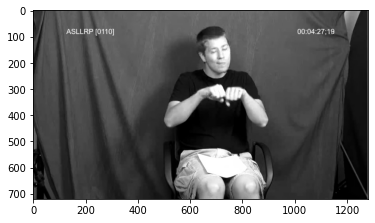

In [ ]:
from imgaug import augmenters as iaa
path = '/content/drive/MyDrive/COS429_Final_Project/BOSTON_DATA4/train/BREAK/42986/42986-0.jpg'

image = cv2.imread(path)
plt.imshow(image)
seq = iaa.Sequential([
                         iaa.CoarseDropout(0.3, size_percent=0.1), 
                         iaa.GammaContrast(2.3), 
                         iaa.Fliplr(p=1)
])



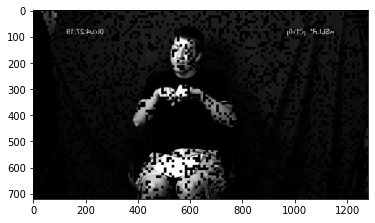

In [ ]:
augimage = seq(image=image)
plt.imshow(augimage)